In [18]:
import gitlab
import pandas as pd
import pickle
import os
import numpy as np

In [2]:
issue_file_path = os.path.join("data", "gitlab-issues.pkl")

In [7]:
if os.path.isfile(issue_file_path):
    issues = pickle.load( open( issue_file_path, "rb" ))
else:
    raise Exception("Please download the data with the Gitlab-issues notebook")

In [8]:
def _get_issues(issues, project):
    '''
    Create Pandas df from the issue data
    '''
    df_issues = pd.DataFrame(columns=['id',
                                      'desc',
                                      'title',
                                      'tags',
                                      'project',
                                      'created_at'])
    for issue in issues:
        df_issues = df_issues.append({'id': issue.id,
                       'desc' : issue.attributes['description'],
                       'title' : issue.attributes['title'],
                       'tags' : issue.attributes['labels'],
                       'project' : project,
                       'created_at' : issue.attributes['created_at']}, ignore_index=True)
    return df_issues

df_issues = pd.concat([_get_issues(issues[0], 'GitLab Community Edition'),
                          _get_issues(issues[1], 'GitLab Enterprise Edition')],
                      ignore_index=True)
df_issues.head()

id                                               desc  \
0  13308948  ### Summary\n\nIf repository mirroring fails (...   
1  13308533  ### Problem to solve\nIt would be nice to be a...   
2  13307635  Hi, I'm doing setup gitlab-ce with docker.\n\n...   
3  13307532  After I backup and restore the gitlab to anoth...   
4  13307385  <!---\nPlease read this!\n\nBefore opening a n...   

                                               title tags  \
0  Text and Background color hides error message ...   []   
1                                      Timed Tickets   []   
2  Set my domain to Project path at new creation ...   []   
3  Registry doesn't work properly after backup an...   []   
4  Filename has been changed if upload via web in...   []   

                    project                created_at  
0  GitLab Community Edition  2018-08-08T06:56:56.268Z  
1  GitLab Community Edition  2018-08-08T06:25:43.101Z  
2  GitLab Community Edition  2018-08-08T04:40:04.743Z  
3  GitLab Community Edition  2018-08-08T04:25:18.021Z  
4  GitLab Community Edition  2018-08-08T04:07:15.305Z

In [13]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
from markdown import markdown
import re
from wordcloud import WordCloud, ImageColorGenerator

from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

nlp = spacy.load('en_core_web_sm')
word_split = re.compile('[^a-zA-Z0-9_\\+\\-/]')

# After checking the first result these should be removed as well
CUSTOM_WORDS = {'ok', 'head', 'ago', 'author1', 'n', 'days', 'yes', 'no', 'hours'}

def cleanText(x):
    html = markdown(x)
    text = ''.join(BeautifulSoup(html).findAll(text=True))
    filtered_words = [word.strip().lower() for word in word_split.split(text) if word not in STOP_WORDS.union(CUSTOM_WORDS)]
    return re.sub(' +',' '," ".join(filtered_words))

In [11]:
df_issues['desc_c'] = df_issues['desc'].map(cleanText)

C:\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


# Wordcloud based on the most popular words in issues

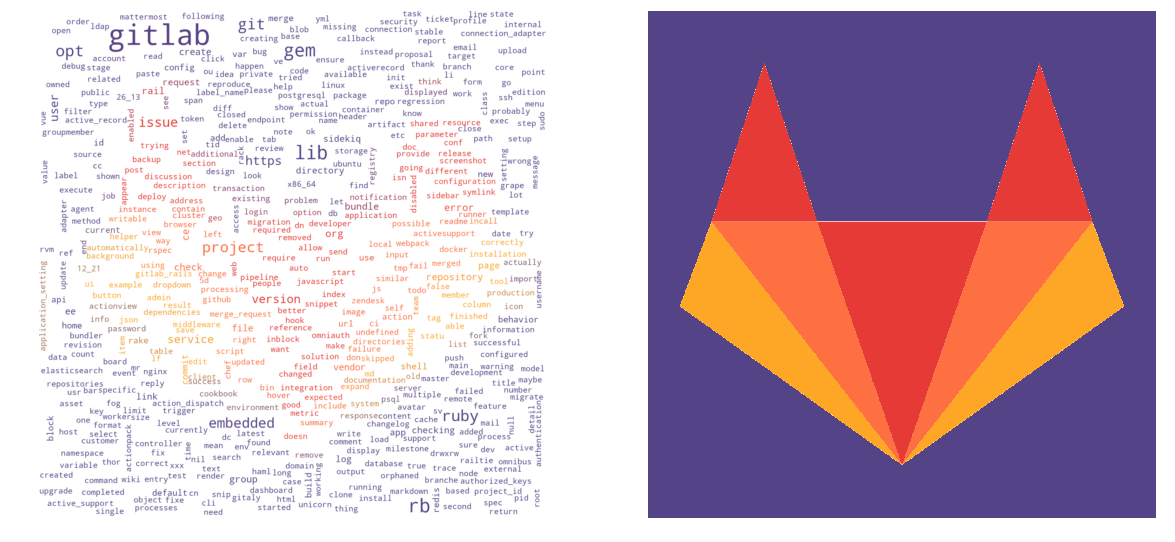

In [19]:
# Create a big chuck of text
text = " ".join(df_issues['desc_c'].values)

#Load image and create a mask from it
gitlab_img = Image.open(os.path.join("misc", "gitlab.png"))
mask = np.array(gitlab_img.convert('RGB'))
wc = WordCloud(background_color="white",
               collocations=False,
               max_words=500,
               mask=mask,
               contour_width = 5,
               max_font_size=90,
               random_state=42)
wc.generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
# plot the wordcloud
fig, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
axes[1].imshow(gitlab_img)
for ax in axes:
    ax.set_axis_off()
plt.show()